In [61]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [71]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50


#Generates a tf.data.Dataset from image files.
data = tf.keras.preprocessing.image_dataset_from_directory(
    "../data",
    seed=100,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7579 files belonging to 5 classes.


In [72]:
class_names = data.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_healthy']

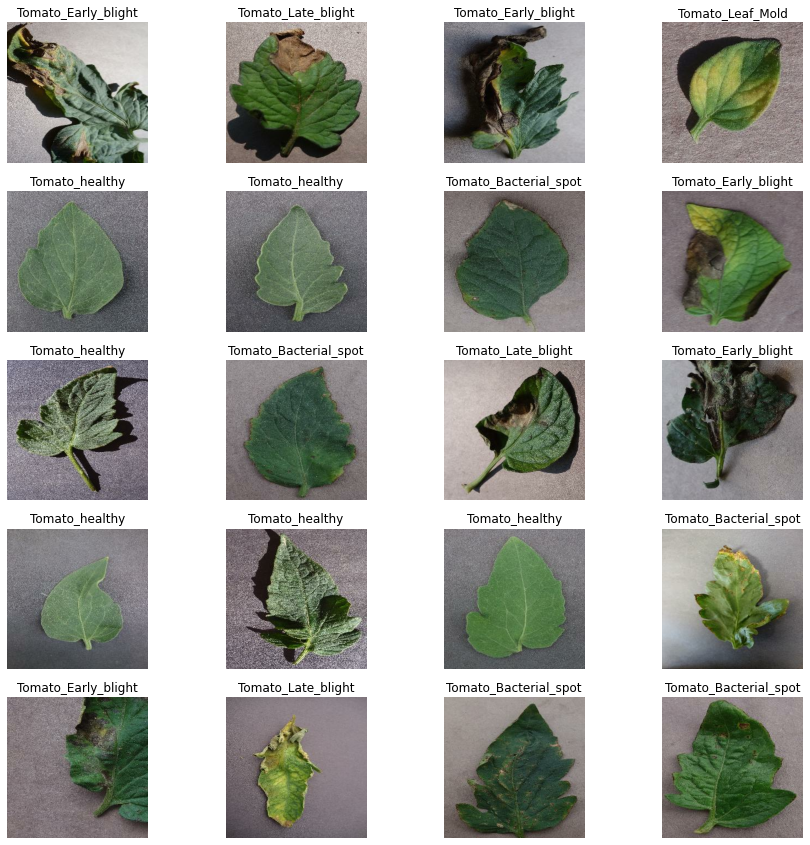

In [98]:
#plotting first few images
plt.figure(figsize=(15, 15))
for image, label in data.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [74]:
def get_dataset_partitions_tf(input_data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    '''
    This function splits the input data into train, validation and test data
    '''
    input_data_size = len(input_data)
    train_size = int(input_data_size * train_split)
    validation_size = int(input_data_size * val_split)
    
    if shuffle:
        input_data = input_data.shuffle(shuffle_size, seed=12)
        
    train_data = input_data.take(train_size)
    validation_data = input_data.skip(train_size).take(validation_size)
    test_data = input_data.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data

In [75]:
train_data, val_data, test_data = get_dataset_partitions_tf(data)
print('Train data size = ', len(train_data))
print('Test data size = ',len(test_data))
print('Validation data size = ',len(val_data))

Train data size =  189
Test data size =  25
Validation data size =  23


In [76]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [77]:
#images are resized to 256*256 
#images are scaled from 0 to 1

resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [78]:
#data augmentation to improve the accuracy of the model
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [60]:
'''
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
'''


In [79]:
#Model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation, 
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),   
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)



In [80]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_16 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (32, 127, 127, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (32, 125, 125, 64)        18496     
                                                     

In [81]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [82]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    verbose=1,
    epochs=50,
)

Epoch 1/50
189/189 [==============================] - 267s 1s/step - loss: 1.2793 - accuracy: 0.4996 - val_loss: 1.4917 - val_accuracy: 0.4837
Epoch 2/50
189/189 [==============================] - 310s 2s/step - loss: 0.6874 - accuracy: 0.7359 - val_loss: 0.6771 - val_accuracy: 0.7364
Epoch 3/50
189/189 [==============================] - 345s 2s/step - loss: 0.5478 - accuracy: 0.7933 - val_loss: 0.6356 - val_accuracy: 0.7867
Epoch 4/50
189/189 [==============================] - 351s 2s/step - loss: 0.4538 - accuracy: 0.8344 - val_loss: 0.8033 - val_accuracy: 0.7636
Epoch 5/50
189/189 [==============================] - 344s 2s/step - loss: 0.3707 - accuracy: 0.8660 - val_loss: 0.3996 - val_accuracy: 0.8628
Epoch 6/50
189/189 [==============================] - 341s 2s/step - loss: 0.3267 - accuracy: 0.8815 - val_loss: 0.5041 - val_accuracy: 0.8302
Epoch 7/50
189/189 [==============================] - 340s 2s/step - loss: 0.3148 - accuracy: 0.8875 - val_loss: 0.6341 - val_accuracy: 0.8261

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [85]:
EPOCHS = 50

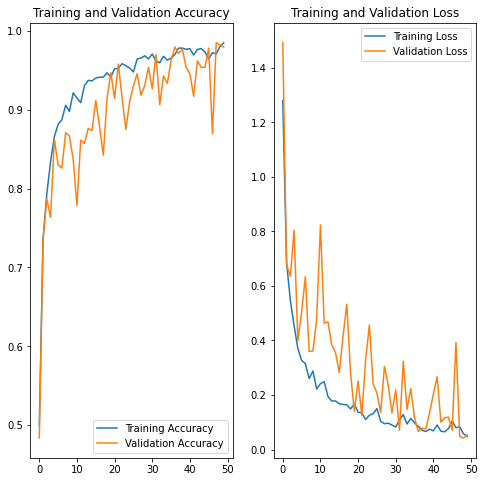

<Figure size 432x288 with 0 Axes>

In [86]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.savefig('Accuracy.png')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Tomato_Bacterial_spot
1/1 [==============================] - 0s 429ms/step
predicted label: Tomato_Bacterial_spot


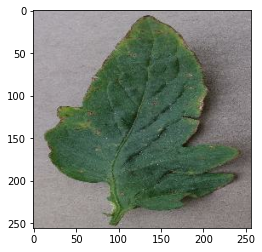

In [99]:
#running prediction on a sample image
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [97]:
# save the model as a h5 file

from tensorflow.keras.models import save_model
filepath = '../models/model1.h5'
tf.keras.models.save_model(
    model, filepath, overwrite=True, include_optimizer=True, save_format='h5',
    signatures=None, options=None, save_traces=True
)